In [1]:
# Import packages
import pandas as pd
import numpy as np

# For MCMC sampling
import pymc as pm
import arviz as az # Visualising mcmc sampling


# For wasserstein distance 
import ot # Can't get this one to work
import scipy.stats as stats 

from scipy.special import logsumexp

# For theme and plotting
import seaborn as sns 
import matplotlib.pyplot as plt

# To change string to latex for plots
from sympy import Symbol, latex 
# To get run time
import time 

# To perform kmeans
from sklearn.cluster import KMeans

sns.set_palette('Dark2')

# Init random seed
RANDOM_SEED = 307
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
# If wishing to reproduce exact results from report please load the following files

# Load samples from original model
samples_sp = np.loadtxt("data/coal/samples_sp.txt", delimiter=",")
samples_er = np.loadtxt("data/coal/samples_er.txt", delimiter=",")
samples_lr = np.loadtxt("data/coal/samples_lr.txt", delimiter=",")

#  Load samples from M_2
samples_sp_2 = np.loadtxt("data/coal/samples_sp_2.txt", delimiter=",")
samples_er_2 = np.loadtxt("data/coal/samples_er_2.txt", delimiter=",")
samples_lr_2 = np.loadtxt("data/coal/samples_lr_2.txt", delimiter=",")

# Load post-processed by IR
samples_cs_sp = np.loadtxt("data/coal/samples_cs_sp.txt", delimiter=",")
samples_cs_er = np.loadtxt("data/coal/samples_cs_er.txt", delimiter=",")
samples_cs_lr = np.loadtxt("data/coal/samples_cs_lr.txt", delimiter=",")

# Load post-processed by AIS
samples_sp_ais = np.loadtxt("data/coal/samples_sp_ais.txt", delimiter=",")
samples_er_ais = np.loadtxt("data/coal/samples_er_ais.txt", delimiter=",")
samples_lr_ais = np.loadtxt("data/coal/samples_lr_ais.txt", delimiter=",")

# Load short MCMC
samples_sp_ws = np.loadtxt("data/coal/samples_sp_ws.txt", delimiter=",")
samples_er_ws = np.loadtxt("data/coal/samples_er_ws.txt", delimiter=",")
samples_lr_ws = np.loadtxt("data/coal/samples_lr_ws.txt", delimiter=",")

# Load post-processed by WS
samples_sp_ws_init = np.loadtxt("data/coal/samples_sp_ws_init.txt", delimiter=",")
samples_er_ws_init = np.loadtxt("data/coal/samples_er_ws_init.txt", delimiter=",")
samples_lr_ws_init = np.loadtxt("data/coal/samples_lr_ws_init.txt", delimiter=",")

# Load samples from M_3
samples_sp_m = np.loadtxt("data/coal/samples_sp_m.txt", delimiter=",")
samples_er_m = np.loadtxt("data/coal/samples_er_m.txt", delimiter=",")
samples_lr_m = np.loadtxt("data/coal/samples_lr_m.txt", delimiter=",")

# Load post-processed by IR
samples_cs_sp_m = np.loadtxt("data/coal/samples_cs_sp_m.txt", delimiter=",")
samples_cs_er_m = np.loadtxt("data/coal/samples_cs_er_m.txt", delimiter=",")
samples_cs_lr_m = np.loadtxt("data/coal/samples_cs_lr_m.txt", delimiter=",")

# Load post-processed by AIS
samples_sp_ais_m2 = np.loadtxt("data/coal/samples_sp_ais_m.txt", delimiter=",")
samples_er_ais_m2 = np.loadtxt("data/coal/samples_er_ais_m.txt", delimiter=",")
samples_lr_ais_m2 = np.loadtxt("data/coal/samples_lr_ais_m.txt", delimiter=",")

# Load short MCMC
samples_sp_ws_m = np.loadtxt("data/coal/samples_sp_ws_m.txt", delimiter=",")
samples_er_ws_m = np.loadtxt("data/coal/samples_er_ws_m.txt", delimiter=",")
samples_lr_ws_m = np.loadtxt("data/coal/samples_lr_ws_m.txt", delimiter=",")

# Load post-processed by WS
samples_sp_ws_m_init = np.loadtxt("data/coal/samples_sp_ws_m_init.txt", delimiter=",")
samples_er_ws_m_init = np.loadtxt("data/coal/samples_er_ws_m_init.txt", delimiter=",")
samples_lr_ws_m_init = np.loadtxt("data/coal/samples_lr_ws_m_init.txt", delimiter=",")

In [131]:
pal = sns.color_palette('Dark2')
print(pal.as_hex())

['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']


In [246]:
# Functions for AIS

def f_j(f_0, f_n, x, beta, rv, n_var = 1):
    # Intermediate distribution on log scale
    
    # Allows for more than one variable input
    if n_var != 1:
      func_input = dict(zip(rv, x))
      result = f_0(func_input)*(beta) + f_n(func_input)*(1-beta)
      return result
    #result = f_0({rv: x})*(beta) + f_n({rv: x})*(1-beta)

    #return result
    return f_0({rv: x})*(beta) + f_n({rv: x})*(1-beta)

def T(x, f, step_size = 0.1, n_steps = 10, n_unknown = 1):
    # MCMC transition step with Random Walk

    count = 0
    
    for t in range(n_steps):
        # Proposal
        #x_prime = x + np.random.randn()
      
        # Needed because o.w. f_j function breaks 
        if n_unknown == 1:
            x_prime = x + np.random.normal(scale = step_size)
        else:
            x_prime = x + np.random.normal(scale = step_size, size = n_unknown)
    
        # Acceptance prob
        # in log scale
        a = f(x_prime) - f(x)
        #print('accept prob: ', a)
        # in log scale
        if np.log(np.random.rand()) < a:
            x = x_prime
            count += 1
        
    print('Acceptance ratio:', count/n_steps)
    #print('Accepted samples:', count)

    return x

def multinomial_resampling(samples, log_weights):
# Function to perform multinomial resampling on given samples and weights
# returning the regenerated samples.
    
    # Check if nan values in posterior probabilities
    if np.isnan(log_weights).any():
        print('Weights contains nan-values')
        return np.nan
    
    # Normalise with log sum exp trick
    weights_norm = np.exp(log_weights - logsumexp(log_weights))
    #weights_norm = weights/(np.sum(weights))
    # Make sure they are properly normalised
    weights_norm = weights_norm/(np.sum(weights_norm))

    # Check if nan values in normalised posterior probabilities
    if np.isnan(weights_norm).any():
        print('Normalise posterior probability contains nan-values')
        return np.nan, np.nan
    #print(np.sum(weights_norm))
    # Resample chain with posterior probabilities
    N = np.size(samples)
    I = np.random.choice(np.arange(N), size = N, replace = True, p = weights_norm)

    # Perform multinomial resampling 
    regenerated_samples = samples[I]

    return regenerated_samples

def simulated_annealing(x, f_0, f_n, n_beta, n_T, n_var, rv, rv_step_size = 1):

    x = np.fromstring(x, sep=' ')

    betas = np.linspace(0, 1, n_beta)
    w = 1
    global run_time_counter_inter 
    global run_time_counter
    #print('in simulated_annealing: ', rv)
    start_time = time.time()
    for n in range(1, len(betas)):
        start_time_inter = time.time()
        # Transition step
        #print(x)
        x = T(x, lambda y: f_j(f_0, f_n, y, betas[n], rv, n_var), step_size = rv_step_size, n_steps = n_T, n_unknown=n_var)

        # Compute weight in log space (log-sum):
        w += (f_j(f_0, f_n, x, betas[n], rv, n_var) - f_j(f_0, f_n, x, betas[n-1], rv, n_var))
        run_time_inter = time.time() - start_time_inter

        run_time_counter_inter += run_time_inter
    run_time = time.time() - start_time 

    run_time_counter += run_time
    x = ' '.join(map(str, x))
    return x, w

def ais(origin_samples, f_0, f_n, rv, n_T = 5, betas = None, n_beta = 10, rv_step_size = 1, n_variables = 1):
    start_time = time.time()

    if betas == None:
    # If no predefined beta inputted, define as a 
        betas = np.linspace(0, 1, n_beta)

    # Sampling & initialise
    n_samples = np.shape(origin_samples)[0] # number of samples post-process
    #if np.shape(np.shape(origin_samples))[0] == 2:
    if n_variables != 1:
       # n_variables = np.shape(origin_samples)[1]
        samples = np.zeros((n_samples, n_variables))
    else:
        #n_variables = 1
        samples = np.zeros(n_samples)

    log_weights = np.zeros(n_samples)

    # Do simulated annealing

    # Timer for each annealing run for each particle
    global run_time_counter
    run_time_counter = 0

    # Timer for each MCMC run for each annealing run for each particle
    global run_time_counter_inter 
    run_time_counter_inter = 0
    #print('In ais:', rv)
    #simulated_annealing_vec = np.vectorize(simulated_annealing)
    simulated_annealing_vec = np.vectorize(simulated_annealing, excluded = (6, 7))

    #Change the samples to nx1 
    str_samples = np.array([' '.join(map(str, row)) for row in origin_samples])

    # Perform annealing runs
    samples, log_weights = simulated_annealing_vec(str_samples, f_0, f_n, n_beta, n_T, n_variables, rv, rv_step_size)
    # Perform multinomial resampling to obtain final regenerated samples
    #regenerated_samples = multinomial_resampling(samples, log_weights)

    run_time = time.time() - start_time 
    print('Run time:', run_time)
    #print(np.var(log_weights))

    log_weight_var = np.var(log_weights)
    samples = np.array([np.fromstring(row, sep=' ') for row in samples])

    return samples, log_weights, run_time, log_weight_var

def ais_slower(origin_samples, f_0, f_n, rv, n_T = 5, betas = None, n_beta = 10, rv_step_size = 1):

    if betas == None:
    # If no predefined beta inputted, define as a 
        betas = np.linspace(0, 1, n_beta)

    # Sampling
    n_samples = np.shape(origin_samples)[0] # number of samples post-process
    n_variables = np.shape(origin_samples)[1]

    # Initialise
    # Initialise
    if n_variables == 1:
        samples = np.zeros(n_samples)
    else:
        samples = np.zeros((n_samples, n_variables))
    w = 1
    log_weights = np.zeros(n_samples)

    start_time = time.time()    
    
    for t in range(n_samples):

        # Iterate through original samples
        x = origin_samples[t] # get first sample from proposal distribution
        w = 1

        # Do simulated annealing
    
        # Iterate through distributions
        for n in range(1, len(betas)):
        # Transition step
            x = T(x, lambda y: f_j(f_0, f_n, y, betas[n], rv, n_var= n_variables), step_size = rv_step_size, n_steps = n_T, n_unknown= n_variables)

        # Compute weight in log space (log-sum):
            w += (f_j(f_0, f_n, x, betas[n], rv, n_var = n_variables) - f_j(f_0, f_n, x, betas[n-1], rv, n_var = n_variables))

        if t % 100 == 0:
            print('postprocessed sample ', t)

        samples[t] = x
        log_weights[t] = w
        print('postprocessed sample:', t)
           
        #if t == 0:
            #print('One run time', time.time() - start_time)
    
    # Perform multinomial resampling to obtain final regenerated samples
    #regenerated_samples = multinomial_resampling(samples, log_weights)
    regenerated_samples = 0
    run_time = time.time() - start_time 
    print('Run time:', run_time)
    #print(np.var(log_weights))
    log_weight_var = np.var(log_weights)

    return samples, log_weights, run_time, log_weight_var 


In [4]:
def multinomial_resampling_multivar(samples, log_weights):
# Function to perform multinomial resampling on given log-posterior functions and weights
# returning the regenerated samples.
    
    start_time = time.time()
    
    # Check if nan values in posterior probabilities
    if np.isnan(log_weights).any():
        print('Weights contains nan-values')
        return np.nan
    
    # Normalise with log sum exp trick
    weights_norm = np.exp(log_weights - logsumexp(log_weights))
    #weights_norm = weights/(np.sum(weights))
    # Make sure they are properly normalised
    weights_norm = weights_norm/(np.sum(weights_norm))

    # Check if nan values in normalised posterior probabilities
    if np.isnan(weights_norm).any():
        print('Normalise posterior probability contains nan-values')
        return np.nan, np.nan

    # Resample chain with posterior probabilities
    N = np.size(samples)
    I = np.random.choice(np.arange(N), size = N, replace = True, p = weights_norm)

    # Perform multinomial resampling 
    regenerated_samples = samples[I]

    run_time = time.time() - start_time 

    return regenerated_samples, run_time

In [70]:
def density_plots(samples_1, samples_2, regenerated_samples, rv):
# Function which takes in model 1 and model 2 samples and the regenerated samples
# and returns the axes for a figure with all correpsonding estimated posterior distributions.

    ax = plt.gca()
    # Make x label to greek symbol for latex
    # Create symbolic variable from string
    x_label = Symbol(rv)
    
    # Plot density for model 1 and 2 samples
    # with the regenerated sample density 
    sns.kdeplot(samples_1, label = r'$\mathcal{M}_1$: MCMC samples', ax = ax)
    sns.kdeplot(samples_2, label = r'$\mathcal{M}_2$: MCMC samples', ax = ax)
    sns.kdeplot(regenerated_samples, label = 'Post-processed samples', ax = ax)

    # Remove top and right lines
    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False)

    # Latex to convert to latex string representation
    ax.set_xlabel(f'${latex(x_label)}$')
    ax.legend()

    return ax 

Text(0.5, 0, 'Year')

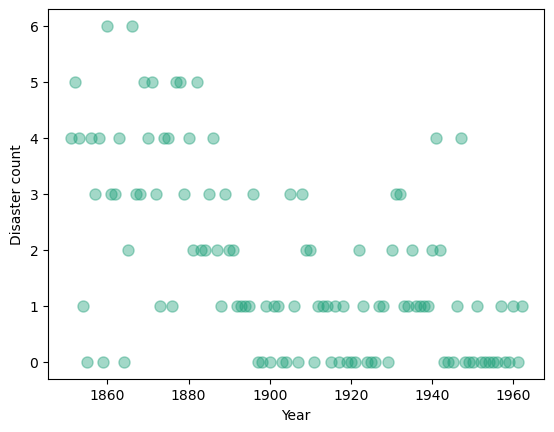

In [6]:
# Read in disaster data
disaster_data = pd.Series(
    [4, 5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 
1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 
0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 
1, 1, 1, 1, 2, 4, 2, 0, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 
1, 0, 0, 1, 0, 1]
)

years = np.arange(1851, 1963)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year")

Original model

In [ ]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

In [4]:
with disaster_model:

    idata = pm.sample(chains = 4, draws = 2500, return_inferencedata = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 29 seconds.


Updated model, $\mathcal{M}_2$

In [ ]:
exp_rate = np.mean(disaster_data)

with pm.Model() as disaster_model_updated:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", exp_rate)
    late_rate = pm.Exponential("late_rate", exp_rate)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

In [5]:
with disaster_model_updated:
    idata_2 = pm.sample(chains = 4, draws = 2500, return_inferencedata = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 27 seconds.


In [9]:
with disaster_model:
    logp_prop = disaster_model.compile_logp()

In [7]:
# Extract and save samples
samples_sp = idata.get_values('switchpoint')
samples_er = idata.get_values('early_rate_log__')
samples_lr = idata.get_values('late_rate_log__')

samples_sp_2 = idata_2.get_values('switchpoint')
samples_er_2 = idata_2.get_values('early_rate_log__')
samples_lr_2 = idata_2.get_values('late_rate_log__')

In [189]:
np.savetxt("data/coal/samples_sp.txt", samples_sp, delimiter=",")
np.savetxt("data/coal/samples_er.txt", samples_er, delimiter=",")
np.savetxt("data/coal/samples_lr.txt", samples_lr, delimiter=",")

np.savetxt("data/coal/samples_sp_2.txt", samples_sp_2, delimiter=",")
np.savetxt("data/coal/samples_er_2.txt", samples_er_2, delimiter=",")
np.savetxt("data/coal/samples_lr_2.txt", samples_lr_2, delimiter=",")

Importance resampling

In [11]:
# Combine the three variables
samples_cs  = np.transpose(np.stack([samples_sp, samples_er, samples_lr]))

In [ ]:
start_time = time.time()

with disaster_model_updated:
    logp_target = disaster_model_updated.compile_logp()

log_weights = np.zeros(np.shape(samples_cs)[0])
rv = ['switchpoint', 'early_rate_log__', 'late_rate_log__']

for i, s in enumerate(samples_cs):
    input = dict(zip(rv, s))
    log_weights[i] = logp_target(input) - logp_prop(input)

samples_cs_sp, rtsp = multinomial_resampling_multivar(samples_cs[:,0], log_weights)
samples_cs_er, rter = multinomial_resampling_multivar(samples_cs[:,1], log_weights)
samples_cs_lr, rtlr = multinomial_resampling_multivar(samples_cs[:,2], log_weights)

print('Time for importance reweighting post-processing', time.time()-start_time)

In [180]:
np.savetxt("data/coal/samples_cs_sp.txt", samples_cs_sp, delimiter=",")
np.savetxt("data/coal/samples_cs_er.txt", samples_cs_er, delimiter=",")
np.savetxt("data/coal/samples_cs_lr.txt", samples_cs_lr, delimiter=",")

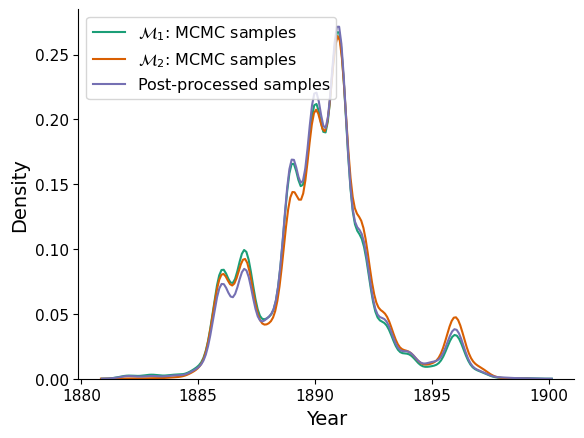

0.15129999999999988
0.16060000000000005


In [203]:
density_plots(samples_sp, samples_sp_2, samples_cs_sp, 'switchpoint')
plt.xlabel('Year', fontsize = 14)
plt.legend(prop={'size': 11.5})
plt.ylabel('Density', fontsize = 14)
plt.xticks(range(1880, 1901, 5))
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/IR_year_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(samples_sp_2, samples_cs_sp))
print(stats.wasserstein_distance(samples_sp, samples_cs_sp))

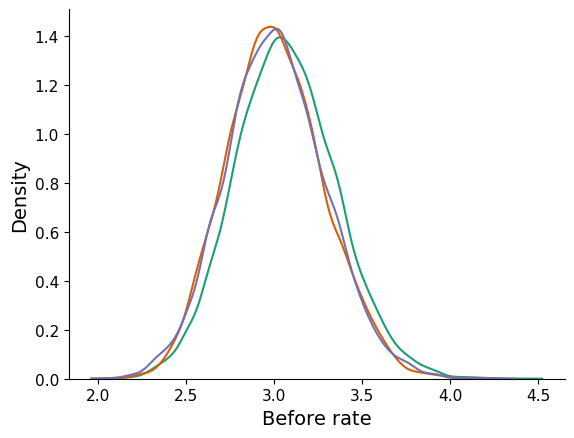

0.006344355867912713
0.05815181762448885


In [200]:
density_plots(np.exp(samples_er), np.exp(samples_er_2), np.exp(samples_cs_er), 'log early rate')
plt.xlabel('Before rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/IR_br_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_er_2), np.exp(samples_cs_er)))
print(stats.wasserstein_distance(np.exp(samples_er), np.exp(samples_cs_er)))

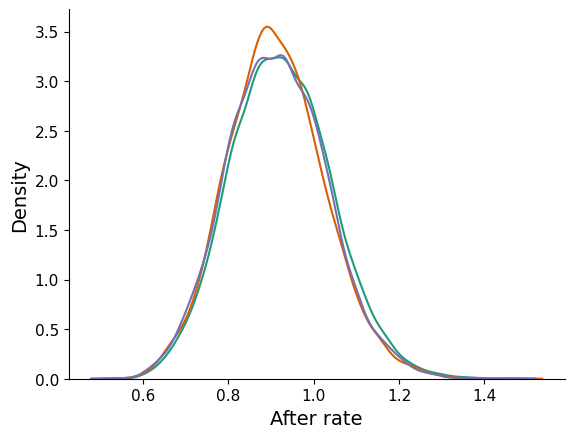

0.003417968871919897
0.010023424228918889


In [201]:
density_plots(np.exp(samples_lr), np.exp(samples_lr_2), np.exp(samples_cs_lr), 'log late rate')
plt.xlabel('After rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/IR_ar_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_lr_2), np.exp(samples_cs_lr)))
print(stats.wasserstein_distance(np.exp(samples_lr), np.exp(samples_cs_lr)))

In [87]:
tmp = pd.DataFrame({'early rate': np.exp(samples_cs_er), 'late rate': np.exp(samples_cs_lr), 'cp': samples_cs_sp})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

In [82]:
tmp = pd.DataFrame({'early rate': np.exp(samples_er_2), 'late rate': np.exp(samples_lr_2), 'cp': samples_sp_2})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_truth = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

In [83]:
tmp = pd.DataFrame({'early rate': np.exp(samples_er), 'late rate': np.exp(samples_lr), 'cp': samples_sp})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_proposal = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

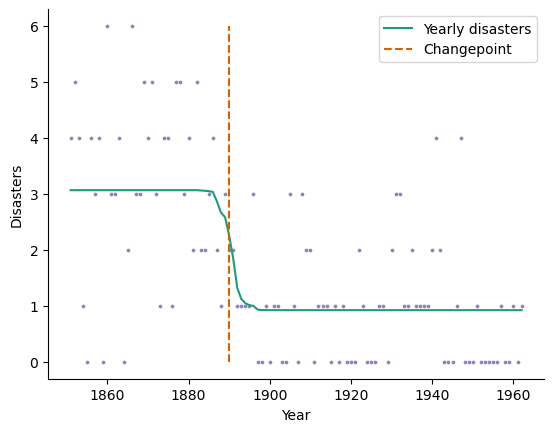

In [85]:
plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_proposal['Expected_disaster'], label = 'Yearly disasters')
plt.vlines(x = np.mean(samples_sp), label = 'Changepoint', linestyle = '--', color = '#d95f02', ymin = 0, ymax = 6)
plt.legend()
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
#plt.savefig('examples/cp/original_results.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

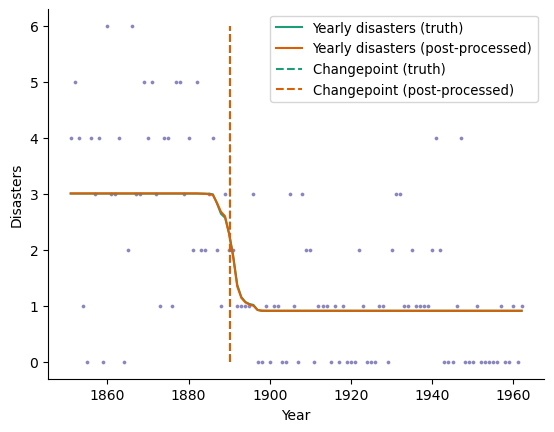

0.07272058010593599
0.10329999999999018


In [89]:
# Compare the true model 2 estimates to the post-processed model estimates
# Importance reweighting

plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth['Expected_disaster'], label = 'Yearly disasters (truth)')
plt.plot(years, disaster_per_day['Expected_disaster'], label = 'Yearly disasters (post-processed)', color = '#d95f02')
plt.vlines(x = np.mean(samples_sp_2), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_cs_sp), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
#plt.savefig('examples/cp/IR_results_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

dif = disaster_per_day_truth['Expected_disaster'] - disaster_per_day['Expected_disaster']
print(np.sqrt(np.dot(dif.T, dif)))
print(np.abs(np.mean(samples_sp_2) - np.mean(samples_cs_sp)))

Annealed importance sampling

In [116]:
# AIS for updated minor


samples_ais, log_weights_ais, run_time_ais, log_weight_var_ais = ais(origin_samples = samples_cs, 
    f_0 = logp_target, f_n = logp_prop, rv = ['switchpoint', 'early_rate_log__', 'late_rate_log__'], 
    n_T  = 5, n_beta = 5, rv_step_size = np.array([1, 0.1, 0.025]), n_variables=3)

start_time = time.time()
samples_sp_ais = multinomial_resampling(samples_ais[:,0], log_weights_ais)
samples_er_ais = multinomial_resampling(samples_ais[:,1], log_weights_ais)
samples_lr_ais = multinomial_resampling(samples_ais[:,2], log_weights_ais)
ais_final_runtime = (time.time()-start_time)+run_time_ais

Run time: 51.70422077178955


In [182]:
np.savetxt("data/coal/samples_sp_ais.txt", samples_sp_ais, delimiter=",")
np.savetxt("data/coal/samples_er_ais.txt", samples_er_ais, delimiter=",")
np.savetxt("data/coal/samples_lr_ais.txt", samples_lr_ais, delimiter=",")

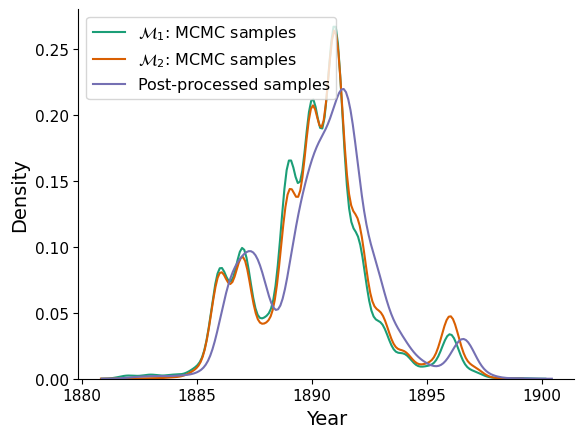

0.36472062280997425
0.49990003048201415
142.8497531414032


In [236]:
density_plots(samples_sp, samples_sp_2, samples_sp_ais, 'switchpoint')
plt.xlabel('Year', fontsize = 14)
plt.legend(prop={'size': 11.5})
plt.ylabel('Density', fontsize = 14)
plt.xticks(range(1880, 1901, 5))
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/AIS_year_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(samples_sp_2, samples_sp_ais))
print(stats.wasserstein_distance(samples_sp, samples_sp_ais))
print(ais_final_runtime)

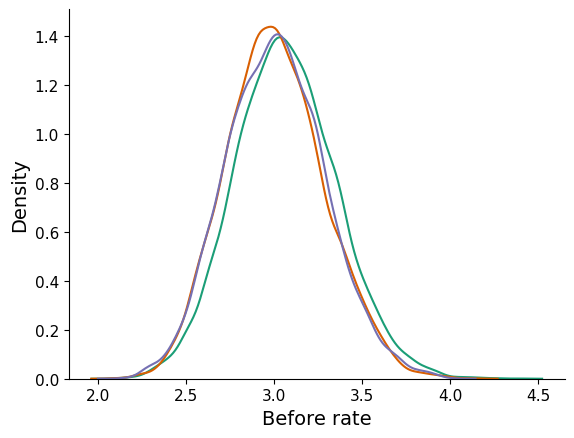

0.006721762421141097
0.057732704796027004


In [235]:
density_plots(np.exp(samples_er), np.exp(samples_er_2), np.exp(samples_er_ais), 'log early rate')
plt.xlabel('Before rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/AIS_br_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_er_2), np.exp(samples_er_ais)))
print(stats.wasserstein_distance(np.exp(samples_er), np.exp(samples_er_ais)))

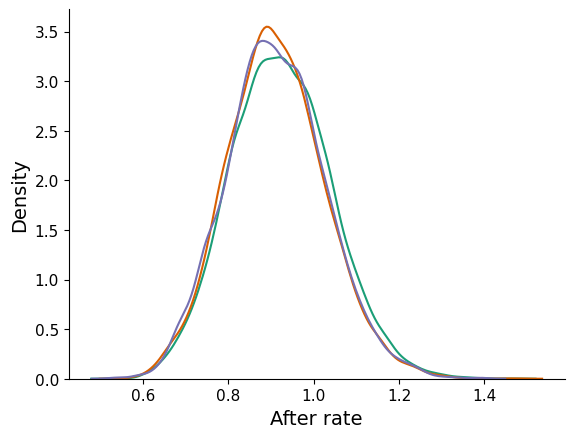

0.0020438870892149357
0.011855369263991881


In [234]:
density_plots(np.exp(samples_lr), np.exp(samples_lr_2), np.exp(samples_lr_ais), 'log late rate')
plt.xlabel('After rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/AIS_ar_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_lr_2), np.exp(samples_lr_ais)))
print(stats.wasserstein_distance(np.exp(samples_lr), np.exp(samples_lr_ais)))

In [120]:
tmp = pd.DataFrame({'early rate': np.exp(samples_er_ais), 'late rate': np.exp(samples_lr_ais), 'cp': samples_sp_ais})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_ais = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

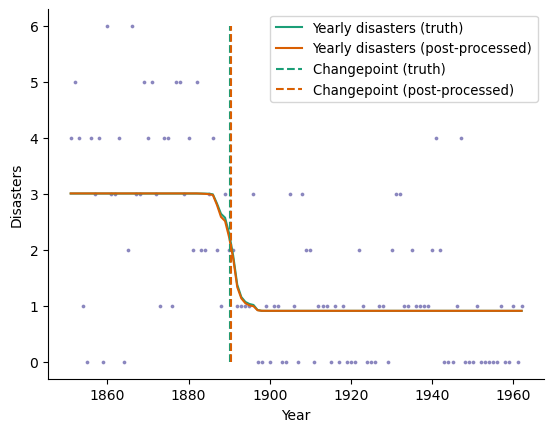

0.22433597470035238
0.13852517038923823


In [122]:
# Compare the true model 2 estimates to the post-processed model estimates

plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth['Expected_disaster'], label = 'Yearly disasters (truth)')
plt.plot(years, disaster_per_day_ais['Expected_disaster'], label = 'Yearly disasters (post-processed)', color = '#d95f02')
plt.vlines(x = np.mean(samples_sp_2), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ais), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
#plt.savefig('examples/cp/AIS_results_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

dif = disaster_per_day_truth['Expected_disaster'] - disaster_per_day_ais['Expected_disaster']
print(np.abs(np.mean(samples_sp_2) - np.mean(samples_sp_ais)))
print(np.sqrt(np.dot(dif.T, dif)))

In [499]:
print('proposed model cp esti', np.mean(samples_sp))
print('updated model truth cp esti', np.mean(samples_sp_2))
print('updated model Importance reweighting cp esti', np.mean(samples_cs_sp))
print('updated model AIS cp esti', np.mean(samples_sp_ais))
#print('updated model WS cp esti', np.mean(samples_sp_ws))

proposed model cp esti 1890.0938
updated model truth cp esti 1890.2726
updated model Importance reweighting cp esti 1890.2779
updated model AIS cp esti 1890.5565657703783


Warm-start MCMC

In [11]:
kmeans = KMeans(n_clusters = 4, random_state = 307)

kmeans.fit(samples_er.reshape(-1, 1))
init_values_er = kmeans.cluster_centers_.squeeze()

kmeans.fit(samples_lr.reshape(-1, 1))
init_values_lr = kmeans.cluster_centers_.squeeze()

kmeans.fit(samples_sp.reshape(-1, 1))
init_values_sp = kmeans.cluster_centers_.squeeze()

init_values = np.transpose(np.stack([init_values_sp, init_values_er, init_values_lr]))

init_dict_var = [{'switchpoint': init[0], 'early_rate_log__': init[1], 'late_rate_log__': init[2]} for init in init_values]

/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Without initial conditions (short MCMC)

In [53]:
# minor change to model
with disaster_model_updated:
    idata_warmstart = pm.sample(chains = 4, draws = 100, return_inferencedata = True, tune = 50)

samples_sp_ws = idata_warmstart.posterior.stack(draws=("chain", "draw"))['switchpoint']
samples_er_ws = idata_warmstart.posterior.stack(draws=("chain", "draw"))['early_rate']
samples_lr_ws = idata_warmstart.posterior.stack(draws=("chain", "draw"))['late_rate']

az.summary(idata_warmstart)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,1897.230,9.062,1886.000,1912.000,4.199,3.178,5.0,10.0,2.87
early_rate,2.794,0.379,2.170,3.463,0.132,0.097,8.0,25.0,1.46
late_rate,0.882,0.119,0.684,1.092,0.023,0.016,28.0,134.0,1.12


In [54]:
tmp = pd.DataFrame({'early rate': (samples_er_ws), 'late rate': (samples_lr_ws), 'cp': samples_sp_ws})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_ws = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

With initial conditions (warm-start MCMC)

In [55]:
with disaster_model_updated:
    idata_warmstart_init = pm.sample(chains = 4, draws = 100, return_inferencedata = True, initvals = init_dict_var, tune = 50)

samples_sp_ws_init = idata_warmstart_init.posterior.stack(draws=("chain", "draw"))['switchpoint']
samples_er_ws_init = idata_warmstart_init.posterior.stack(draws=("chain", "draw"))['early_rate']
samples_lr_ws_init = idata_warmstart_init.posterior.stack(draws=("chain", "draw"))['late_rate']

az.summary(idata_warmstart_init)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,1890.625,2.637,1886.000,1896.000,1.042,0.774,8.0,52.0,1.58
early_rate,2.995,0.286,2.413,3.511,0.023,0.016,168.0,309.0,1.04
late_rate,0.918,0.115,0.717,1.138,0.012,0.008,87.0,329.0,1.04


In [183]:
np.savetxt("data/coal/samples_sp_ws.txt", samples_sp_ws, delimiter=",")
np.savetxt("data/coal/samples_er_ws.txt", samples_er_ws, delimiter=",")
np.savetxt("data/coal/samples_lr_ws.txt", samples_lr_ws, delimiter=",")

np.savetxt("data/coal/samples_sp_ws_init.txt", samples_sp_ws_init, delimiter=",")
np.savetxt("data/coal/samples_er_ws_init.txt", samples_er_ws_init, delimiter=",")
np.savetxt("data/coal/samples_lr_ws_init.txt", samples_lr_ws_init, delimiter=",")

In [56]:
tmp = pd.DataFrame({'early rate': (samples_er_ws_init), 'late rate': (samples_lr_ws_init), 'cp': samples_sp_ws_init})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_ws_init = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

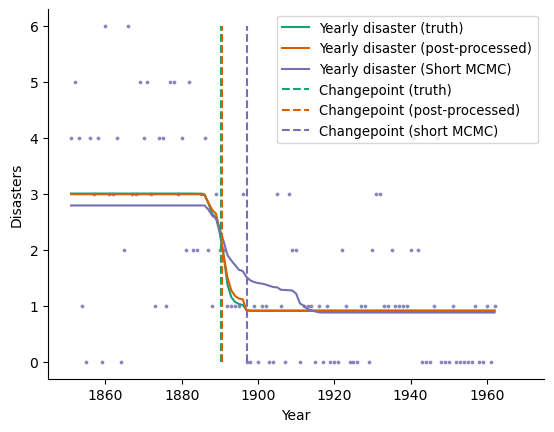

In [72]:
# Compare the true model 2 estimates to the post-processed model estimates

plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth['Expected_disaster'], label = 'Yearly disaster (truth)')
plt.plot(years, disaster_per_day_ws_init['Expected_disaster'], label = 'Yearly disaster (post-processed)', color = '#d95f02')
plt.plot(years, disaster_per_day_ws['Expected_disaster'], label = 'Yearly disaster (Short MCMC)', color = '#7570b3')
plt.vlines(x = np.mean(samples_sp_2), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ws_init), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ws), label = 'Changepoint (short MCMC)', color = '#7570b3', linestyle = '--', ymin = 0, ymax = 6)
plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
plt.xlim((1845, 1975))
#plt.savefig('examples/cp/WS_results_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [73]:
dif = disaster_per_day_truth['Expected_disaster'] - disaster_per_day_ws_init['Expected_disaster']
print(np.abs(np.mean(samples_sp_2) - np.mean(samples_sp_ws_init)))
print(np.sqrt(np.dot(dif.T, dif)))

print(stats.wasserstein_distance(samples_sp_2, samples_sp_ws_init))
print(stats.wasserstein_distance(np.exp(samples_er_2), samples_er_ws_init))
print(stats.wasserstein_distance(np.exp(samples_lr_2), samples_lr_ws_init))

<xarray.DataArray 'switchpoint' ()>
array(0.373)
0.28532109871117955
0.39119999999999994
0.017857716447836264
0.0069043859764712405


In [191]:
print(np.abs(np.mean(samples_sp_2) - np.mean(samples_sp_ws)))

<xarray.DataArray 'switchpoint' ()>
array(6.978)


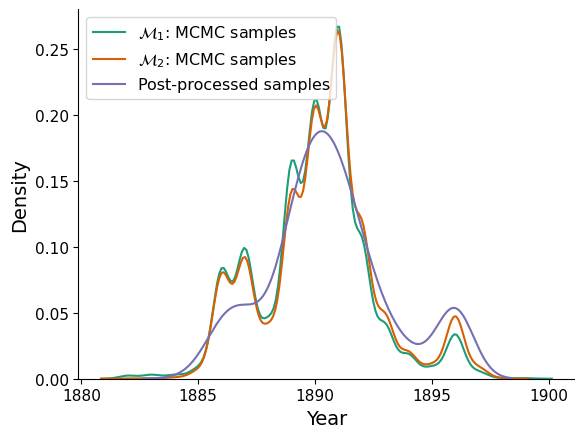

0.39119999999999994
0.6505000000000001


In [207]:
density_plots((samples_sp), (samples_sp_2), (samples_sp_ws_init), 'log late rate')
plt.xlabel('Year', fontsize = 14)
plt.legend(prop={'size': 11.5})
plt.ylabel('Density', fontsize = 14)
plt.xticks(range(1880, 1901, 5))
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/WS_sp_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance((samples_sp_2), samples_sp_ws_init))
print(stats.wasserstein_distance((samples_sp), samples_sp_ws_init))

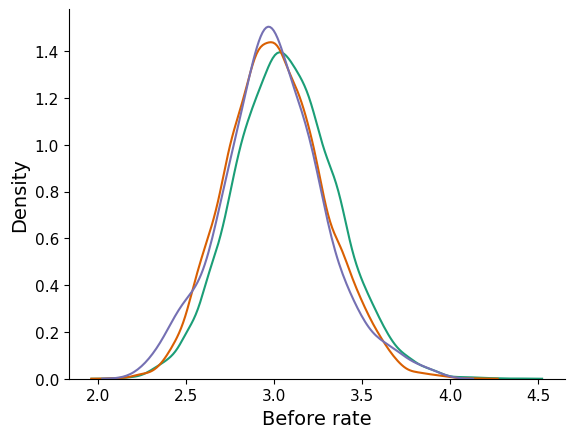

0.017857716447836264
0.07227223124224062


In [221]:
density_plots(np.exp(samples_er), np.exp(samples_er_2), (samples_er_ws_init), 'log late rate')
plt.xlabel('Before rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/WS_br_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_er_2), samples_er_ws_init))
print(stats.wasserstein_distance(np.exp(samples_er), samples_er_ws_init))

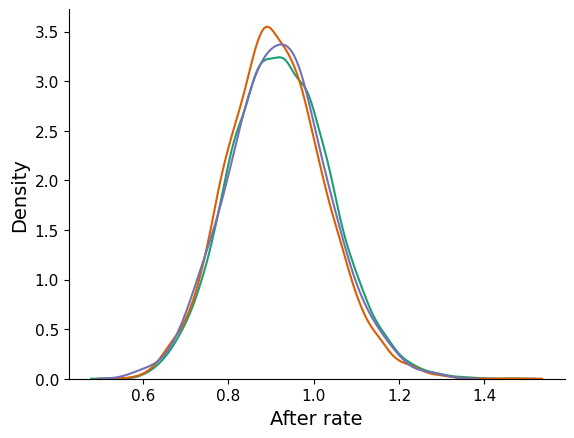

0.0069043859764712405
0.00713655064383936


In [222]:
density_plots(np.exp(samples_lr), np.exp(samples_lr_2), (samples_lr_ws_init), 'log late rate')
plt.xlabel('After rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/WS_ar_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_lr_2), samples_lr_ws_init))
print(stats.wasserstein_distance(np.exp(samples_lr), samples_lr_ws_init))

Updated model: $\mathcal{M}_3$

In [ ]:
with pm.Model() as disaster_model_updated_major:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 15)
    late_rate = pm.Exponential("late_rate", 10)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

In [14]:
with disaster_model_updated_major:

    idata_major = pm.sample(chains = 4, draws = 2500, return_inferencedata = False)

samples_sp_m = idata_major.get_values('switchpoint')
samples_er_m = idata_major.get_values('early_rate_log__')
samples_lr_m = idata_major.get_values('late_rate_log__')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 28 seconds.


In [184]:
np.savetxt("data/coal/samples_sp_m.txt", samples_sp_m, delimiter=",")
np.savetxt("data/coal/samples_er_m.txt", samples_er_m, delimiter=",")
np.savetxt("data/coal/samples_lr_m.txt", samples_lr_m, delimiter=",")

Importance resampling

In [90]:
start_time = time.time()

with disaster_model_updated_major:
    logp_target_m = disaster_model_updated_major.compile_logp()

log_weights = np.zeros(np.shape(samples_cs)[0])
rv = ['switchpoint', 'early_rate_log__', 'late_rate_log__']

for i, s in enumerate(samples_cs):
    input = dict(zip(rv, s))
    log_weights[i] = logp_target_m(input) - logp_prop(input)

samples_cs_sp_m, rtsp = multinomial_resampling_multivar(samples_cs[:,0], log_weights)
samples_cs_er_m, rter = multinomial_resampling_multivar(samples_cs[:,1], log_weights)
samples_cs_lr_m, rtlr = multinomial_resampling_multivar(samples_cs[:,2], log_weights)

print('Time for importance reweighting post-processing', time.time()-start_time)

Time for importance reweighting post-processing 1.0693697929382324


In [185]:
np.savetxt("data/coal/samples_cs_sp_m.txt", samples_cs_sp_m, delimiter=",")
np.savetxt("data/coal/samples_cs_er_m.txt", samples_cs_er_m, delimiter=",")
np.savetxt("data/coal/samples_cs_lr_m.txt", samples_cs_lr_m, delimiter=",")

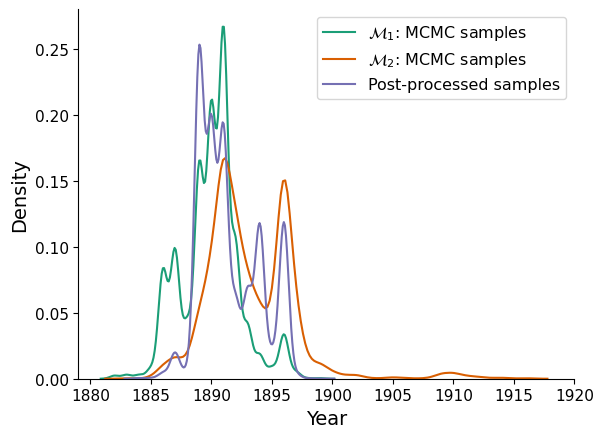

1.8783
1.4207


In [212]:
density_plots(samples_sp, samples_sp_m, samples_cs_sp_m, 'switchpoint')
plt.xlabel('Year', fontsize = 14)
plt.legend(prop={'size': 11.5})
plt.ylabel('Density', fontsize = 14)
plt.xticks(range(1880, 1921, 5))
plt.tick_params(axis='both', which='major', labelsize=11)
#plt.savefig('examples/cp/IR_year_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(samples_sp_m, samples_cs_sp_m))
print(stats.wasserstein_distance(samples_sp, samples_cs_sp_m))

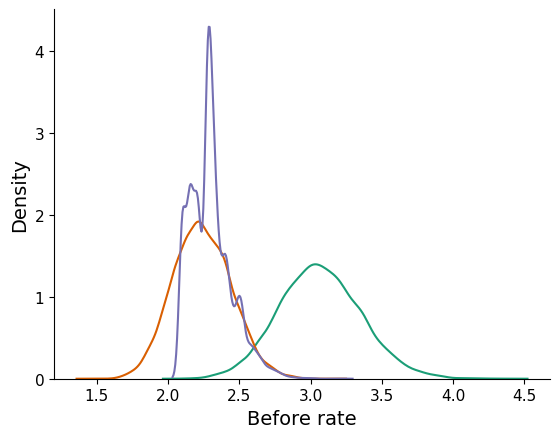

0.06366423021631594
0.7684694825214906


In [223]:
density_plots(np.exp(samples_er), np.exp(samples_er_m), np.exp(samples_cs_er_m), 'log early rate')
plt.xlabel('Before rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/IR_br_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_er_m), np.exp(samples_cs_er_m)))
print(stats.wasserstein_distance(np.exp(samples_er), np.exp(samples_cs_er_m)))

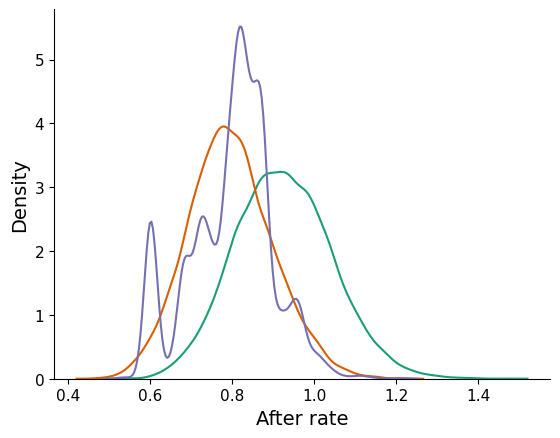

0.017118051941137604
0.1264632586934955


In [224]:
density_plots(np.exp(samples_lr), np.exp(samples_lr_m), np.exp(samples_cs_lr_m), 'log late rate')
plt.xlabel('After rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/IR_ar_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_lr_m), np.exp(samples_cs_lr_m)))
print(stats.wasserstein_distance(np.exp(samples_lr), np.exp(samples_cs_lr_m)))

In [98]:
tmp = pd.DataFrame({'early rate': np.exp(samples_er_m), 'late rate': np.exp(samples_lr_m), 'cp': samples_sp_m})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_truth_m = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

In [99]:
tmp = pd.DataFrame({'early rate': np.exp(samples_cs_er_m), 'late rate': np.exp(samples_cs_lr_m), 'cp': samples_cs_sp_m})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_m = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

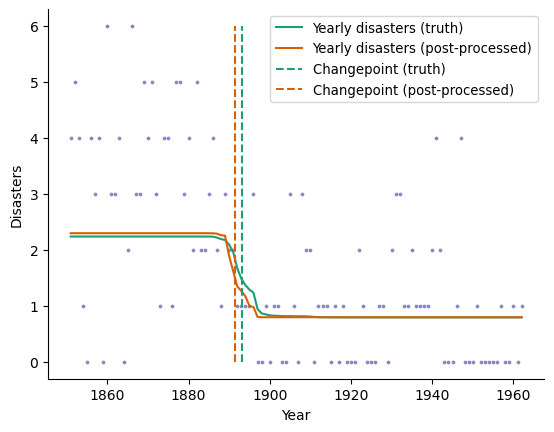

In [101]:
# Compare the true model 2 estimates to the post-processed model estimates
# Importance reweighting

plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth_m['Expected_disaster'], label = 'Yearly disasters (truth)')
plt.plot(years, disaster_per_day_m['Expected_disaster'], label = 'Yearly disasters (post-processed)', color = '#d95f02')
plt.vlines(x = np.mean(samples_sp_m), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_cs_sp_m), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
#plt.savefig('examples/cp/IR_results_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [102]:
dif = disaster_per_day_truth_m['Expected_disaster'] - disaster_per_day_m['Expected_disaster']
print(np.abs(np.mean(samples_sp_m) - np.mean(samples_cs_sp_m)))
print(np.sqrt(np.dot(dif.T, dif)))

1.8209000000001652
0.8210219677597193


Annealed importance sampling

In [137]:
samples_ais_m2, log_weights_ais_m2, run_time_ais_m2, log_weight_var_ais_m2 = ais(origin_samples = samples_cs, 
    f_0 = logp_target_m, f_n = logp_prop, rv = ['switchpoint', 'early_rate_log__', 'late_rate_log__'], 
    n_T  = 5, n_beta = 12, rv_step_size = np.array([1, 0.1, 0.025]), n_variables=3)

start_time = time.time()
samples_sp_ais_m2 = multinomial_resampling(samples_ais_m2[:,0], log_weights_ais_m2)
samples_er_ais_m2 = multinomial_resampling(samples_ais_m2[:,1], log_weights_ais_m2)
samples_lr_ais_m2 = multinomial_resampling(samples_ais_m2[:,2], log_weights_ais_m2)
ais_final_runtime2 = (time.time()-start_time)+run_time_ais_m2
print(ais_final_runtime2)

Run time: 128.94402718544006
128.94907021522522


In [186]:
np.savetxt("data/coal/samples_sp_ais_m.txt", samples_sp_ais_m2, delimiter=",")
np.savetxt("data/coal/samples_er_ais_m.txt", samples_er_ais_m2, delimiter=",")
np.savetxt("data/coal/samples_lr_ais_m.txt", samples_lr_ais_m2, delimiter=",")

In [138]:
tmp = pd.DataFrame({'early rate': np.exp(samples_er_ais_m2), 'late rate': np.exp(samples_lr_ais_m2), 'cp': samples_sp_ais_m2})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_ais_m2 = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

In [139]:
dif = disaster_per_day_truth_m['Expected_disaster'] - disaster_per_day_ais_m2['Expected_disaster']
print(np.abs(np.mean(samples_sp_m) - np.mean(samples_sp_ais_m2)))
print(np.sqrt(np.dot(dif.T, dif)))

0.016574952752534955
0.28871130585582255


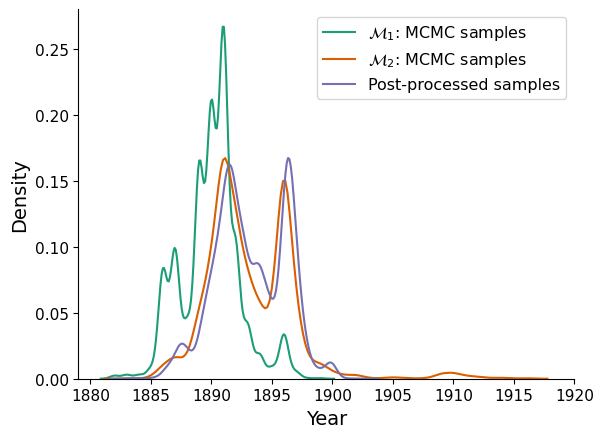

0.5704759669102646
3.2527749527523566


In [229]:
density_plots(samples_sp, samples_sp_m, samples_sp_ais_m2, 'switchpoint')
plt.xlabel('Year', fontsize = 14)
plt.legend(prop={'size': 11.5})
plt.ylabel('Density', fontsize = 14)
plt.xticks(range(1880, 1921, 5))
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/AIS_year_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(samples_sp_m, samples_sp_ais_m2))
print(stats.wasserstein_distance(samples_sp, samples_sp_ais_m2))

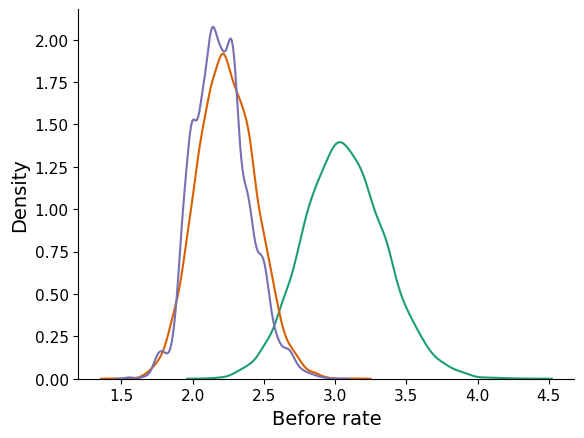

0.03940985910740825
0.8658696085443445


In [230]:
density_plots(np.exp(samples_er), np.exp(samples_er_m), np.exp(samples_er_ais_m2), 'log early rate')
plt.xlabel('Before rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/AIS_br_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_er_m), np.exp(samples_er_ais_m2)))
print(stats.wasserstein_distance(np.exp(samples_er), np.exp(samples_er_ais_m2)))

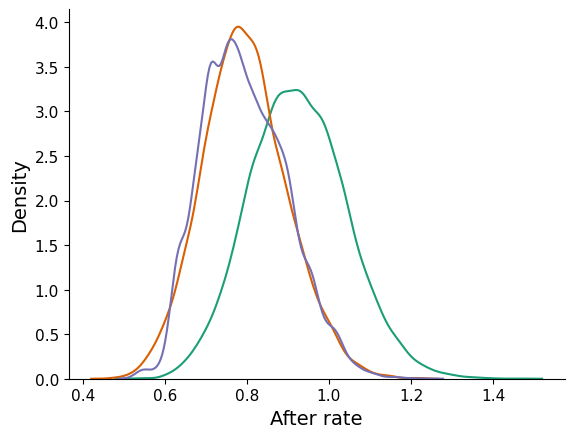

0.005196616922088312
0.12955104466875123


In [231]:
density_plots(np.exp(samples_lr), np.exp(samples_lr_m), np.exp(samples_lr_ais_m2), 'log late rate')
plt.xlabel('After rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/AIS_ar_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_lr_m), np.exp(samples_lr_ais_m2)))
print(stats.wasserstein_distance(np.exp(samples_lr), np.exp(samples_lr_ais_m2)))

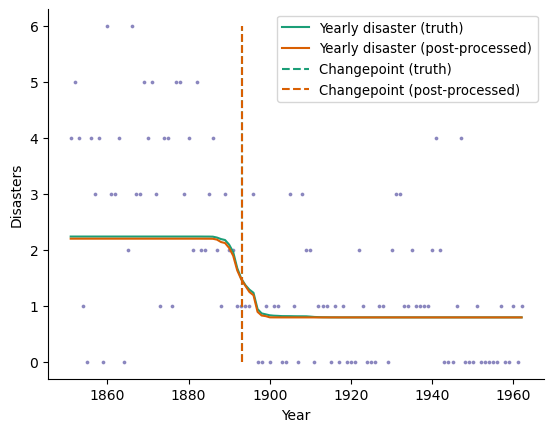

0.016574952752534955
0.28871130585582255


In [156]:
# Compare the true model 2 estimates to the post-processed model estimates
# Annealed importance sampling

plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth_m['Expected_disaster'], label = 'Yearly disaster (truth)')
plt.plot(years, disaster_per_day_ais_m2['Expected_disaster'], label = 'Yearly disaster (post-processed)', color = '#d95f02')
plt.vlines(x = np.mean(samples_sp_m), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ais_m2), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
plt.savefig('examples/cp/AIS_results_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

dif = disaster_per_day_truth_m['Expected_disaster'] - disaster_per_day_ais_m2['Expected_disaster']
print(np.abs(np.mean(samples_sp_m) - np.mean(samples_sp_ais_m2)))
print(np.sqrt(np.dot(dif.T, dif)))

Warm-start MCMC

In [387]:
kmeans = KMeans(n_clusters = 4, random_state = 307)

kmeans.fit(samples_er.reshape(-1, 1))
init_values_er = kmeans.cluster_centers_.squeeze()

kmeans.fit(samples_lr.reshape(-1, 1))
init_values_lr = kmeans.cluster_centers_.squeeze()

kmeans.fit(samples_sp.reshape(-1, 1))
init_values_sp = kmeans.cluster_centers_.squeeze()

init_values = np.transpose(np.stack([init_values_sp, init_values_er, init_values_lr]))

init_dict_var = [{'switchpoint': init[0], 'early_rate_log__': init[1], 'late_rate_log__': init[2]} for init in init_values]

/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ingahuldarmann/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Without initial conditions (short MCMC)

In [26]:
with disaster_model_updated_major:
    idata_warmstart_m = pm.sample(chains = 4, draws = 100, return_inferencedata = True, tune = 50)
print(az.summary(idata_warmstart_m))

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


                 mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
switchpoint  1902.178  8.444  1889.000  1912.000      3.870    2.924   
early_rate      2.087  0.237     1.674     2.494      0.061    0.044   
late_rate       0.773  0.112     0.578     0.997      0.019    0.013   

             ess_bulk  ess_tail  r_hat  
switchpoint       5.0      21.0   2.31  
early_rate       15.0     116.0   1.20  
late_rate        36.0      67.0   1.10  


In [27]:
samples_sp_ws_m = idata_warmstart_m.posterior.stack(draws=("chain", "draw"))['switchpoint']
samples_er_ws_m = idata_warmstart_m.posterior.stack(draws=("chain", "draw"))['early_rate']
samples_lr_ws_m = idata_warmstart_m.posterior.stack(draws=("chain", "draw"))['late_rate']

In [187]:
np.savetxt("data/coal/samples_sp_ws_m.txt", samples_sp_ws_m, delimiter=",")
np.savetxt("data/coal/samples_er_ws_m.txt", samples_er_ws_m, delimiter=",")
np.savetxt("data/coal/samples_lr_ws_m.txt", samples_lr_ws_m, delimiter=",")

In [28]:
tmp = pd.DataFrame({'early rate': (samples_er_ws_m), 'late rate': (samples_lr_ws_m), 'cp': samples_sp_ws_m})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_ws_m = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

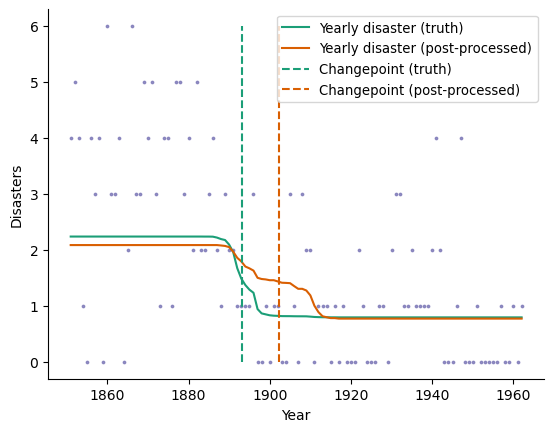

In [29]:
plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth_m['Expected_disaster'], label = 'Yearly disaster (truth)')
plt.plot(years, disaster_per_day_ws_m['Expected_disaster'], label = 'Yearly disaster (post-processed)', color = '#d95f02')
plt.vlines(x = np.mean(samples_sp_m), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ws_m), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
#plt.savefig('examples/cp/results_minor.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

With intial conditions (warm-start MCMC)

In [41]:
with disaster_model_updated_major:
    idata_warmstart_m_init = pm.sample(chains = 4, draws = 100, return_inferencedata = True, initvals = init_dict_var, tune = 50)

az.summary(idata_warmstart_m_init)

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 27 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,1894.312,2.784,1890.000,1899.000,1.083,0.803,7.0,32.0,1.59
early_rate,2.230,0.204,1.852,2.559,0.018,0.013,142.0,276.0,1.03
late_rate,0.780,0.099,0.598,0.953,0.007,0.005,202.0,257.0,1.01


In [42]:
samples_sp_ws_m_init = idata_warmstart_m_init.posterior.stack(draws=("chain", "draw"))['switchpoint']
samples_er_ws_m_init = idata_warmstart_m_init.posterior.stack(draws=("chain", "draw"))['early_rate']
samples_lr_ws_m_init = idata_warmstart_m_init.posterior.stack(draws=("chain", "draw"))['late_rate']

In [188]:
np.savetxt("data/coal/samples_sp_ws_m_init.txt", samples_sp_ws_m_init, delimiter=",")
np.savetxt("data/coal/samples_er_ws_m_init.txt", samples_er_ws_m_init, delimiter=",")
np.savetxt("data/coal/samples_lr_ws_m_init.txt", samples_lr_ws_m_init, delimiter=",")

In [43]:
tmp = pd.DataFrame({'early rate': (samples_er_ws_m_init), 'late rate': (samples_lr_ws_m_init), 'cp': samples_sp_ws_m_init})
N = 112
E_lambda_S = np.zeros(N)

# Generate Monte Carlo estimate for each i
for i, year in enumerate(years):
    # Condition for lambda
    tmp_lambda = tmp.assign(lambda_ = np.where(year <= tmp['cp'], tmp['early rate'], tmp['late rate']))
    # Monte Carlo estimate
    E_lambda_S[i] = tmp_lambda['lambda_'].mean()

# Combine results into a DataFrame
disaster_per_day_ws_m_init = pd.DataFrame({
    "Year": years,
    "Disaster": disaster_data,
    "Expected_disaster": E_lambda_S
})

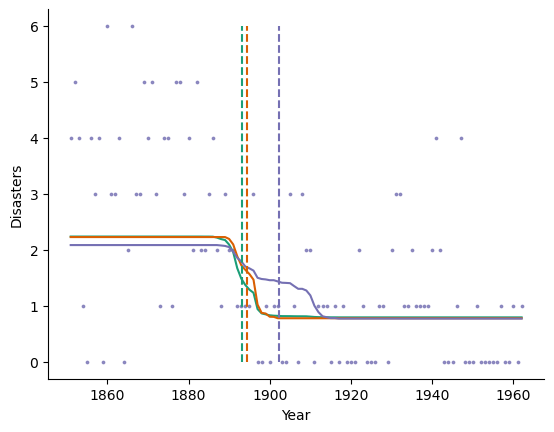

In [61]:
# Compare the true model 2 estimates to the post-processed model estimates

plt.scatter(years, disaster_data, color = '#7570b3', s = 3, alpha = 0.75)
plt.plot(years, disaster_per_day_truth_m['Expected_disaster'], label = 'Yearly disaster (truth)')
plt.plot(years, disaster_per_day_ws_m_init['Expected_disaster'], label = 'Yearly disaster (post-processed)', color = '#d95f02')
plt.plot(years, disaster_per_day_ws_m['Expected_disaster'], label = 'Yearly disaster (Short MCMC)', color = '#7570b3')
plt.vlines(x = np.mean(samples_sp_m), label = 'Changepoint (truth)', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ws_m_init), label = 'Changepoint (post-processed)', color = '#d95f02', linestyle = '--', ymin = 0, ymax = 6)
plt.vlines(x = np.mean(samples_sp_ws_m), label = 'Changepoint (short MCMC)', color = '#7570b3', linestyle = '--', ymin = 0, ymax = 6)
#plt.legend(prop={'size': 9.5})
plt.gca().spines['right'].set_visible(False) 
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Disasters')
#plt.savefig('examples/cp/WS_results_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [74]:
dif = disaster_per_day_truth_m['Expected_disaster'] - disaster_per_day_ws_m_init['Expected_disaster']
print(np.abs(np.mean(samples_sp_m) - np.mean(samples_sp_ws_m_init)))
print(np.sqrt(np.dot(dif.T, dif)))

print(stats.wasserstein_distance(samples_sp_m, samples_sp_ws_m_init))
print(stats.wasserstein_distance(np.exp(samples_er_m), samples_er_ws_m_init))
print(stats.wasserstein_distance(np.exp(samples_lr_m), samples_lr_ws_m_init))

<xarray.DataArray 'switchpoint' ()>
array(1.0882)
0.6150667302961628
1.4500000000000002
0.017604802678443006
0.016092414628922663


In [190]:
print(np.abs(np.mean(samples_sp_m) - np.mean(samples_sp_ws_m)))

<xarray.DataArray 'switchpoint' ()>
array(8.9532)


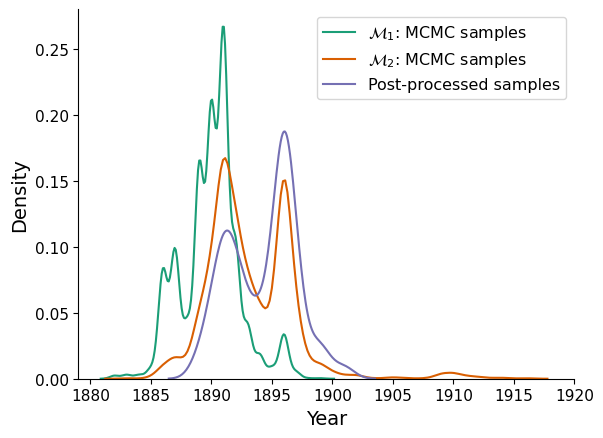

1.4500000000000002
4.3244


In [217]:
density_plots((samples_sp), (samples_sp_m), samples_sp_ws_m_init, '')
plt.xlabel('Year', fontsize = 14)
plt.legend(prop={'size': 11.5})
plt.ylabel('Density', fontsize = 14)
plt.xticks(range(1880, 1921, 5))
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/WS_sp_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance((samples_sp_m), (samples_sp_ws_m_init)))
print(stats.wasserstein_distance((samples_sp), (samples_sp_ws_m_init)))

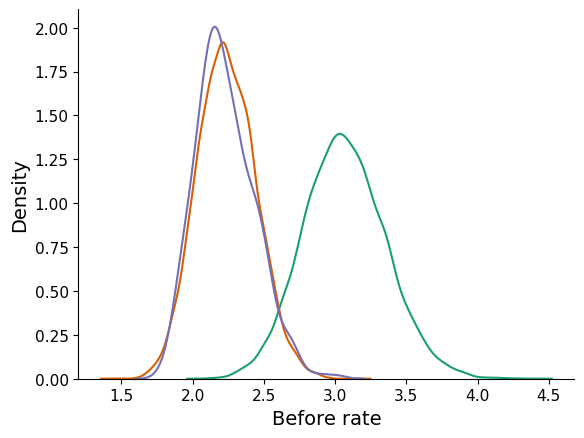

0.017604802678443006
0.8372198381291537


In [232]:
density_plots(np.exp(samples_er), np.exp(samples_er_m), samples_er_ws_m_init, '')
plt.xlabel('Before rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/WS_br_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_er_m), (samples_er_ws_m_init)))
print(stats.wasserstein_distance(np.exp(samples_er), (samples_er_ws_m_init)))

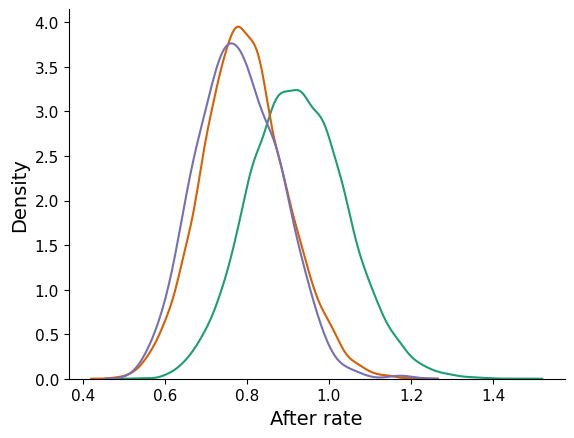

0.016092414628922663
0.14445835824192896


In [233]:
density_plots(np.exp(samples_lr), np.exp(samples_lr_m), samples_lr_ws_m_init, '')
plt.xlabel('After rate', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.gca().get_legend().remove()
plt.tick_params(axis='both', which='major', labelsize=11)
plt.savefig('examples/cp/WS_ar_major.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

print(stats.wasserstein_distance(np.exp(samples_lr_m), (samples_lr_ws_m_init)))
print(stats.wasserstein_distance(np.exp(samples_lr), (samples_lr_ws_m_init)))